# About Dataset Used

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of the transactions and 99,8%   of the correct transaction.

Class 0 - fraud transaction
Class 1 - correct transaction

The datasets contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

* Features V1, V2, ... V28 are the principal components obtained with PCA;
* The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
* Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Data Preprocessing

In [3]:
df = pd.read_csv("/Users/karthiksagar/Downloads/Sem-5/ML Theory/CreditCardFraudDetection/Dataset/creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    284315
1       492
Name: count, dtype: int64


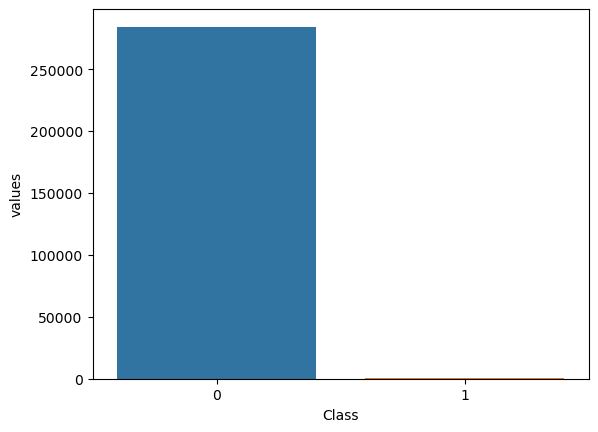

In [6]:
temp = df['Class'].value_counts(normalize=False)
temp_df = pd.DataFrame({'Class': temp.index,'values': temp.values})
#viz
sns.color_palette("flare", as_cmap=True)
sns.barplot(temp_df, x='Class', y='values')
print(temp)

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced in respect with target variable Class.

In [7]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
data = pd.DataFrame(tmp)
data.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
data.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


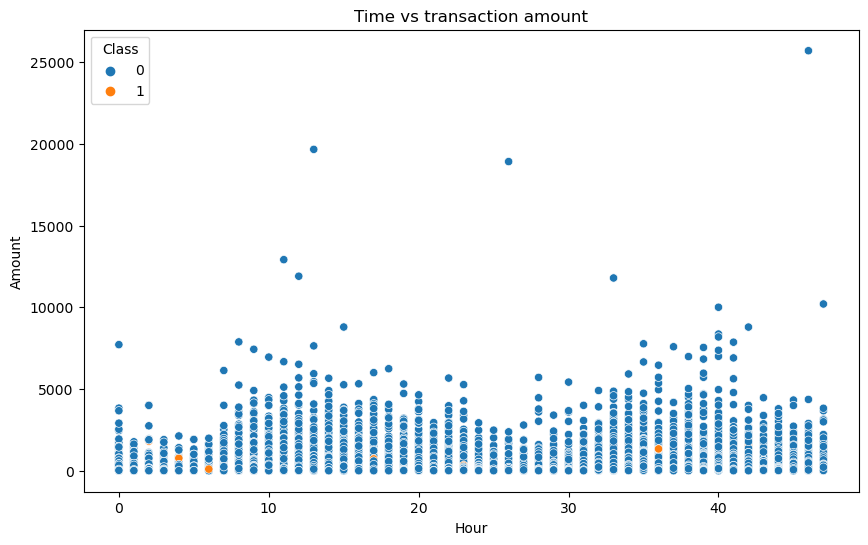

In [8]:
plt.figure(figsize=(10,6))
sns.color_palette("mako", as_cmap=True)
sns.scatterplot(data= df, x='Hour', y='Amount', hue='Class')
plt.title("Time vs transaction amount")
plt.show()

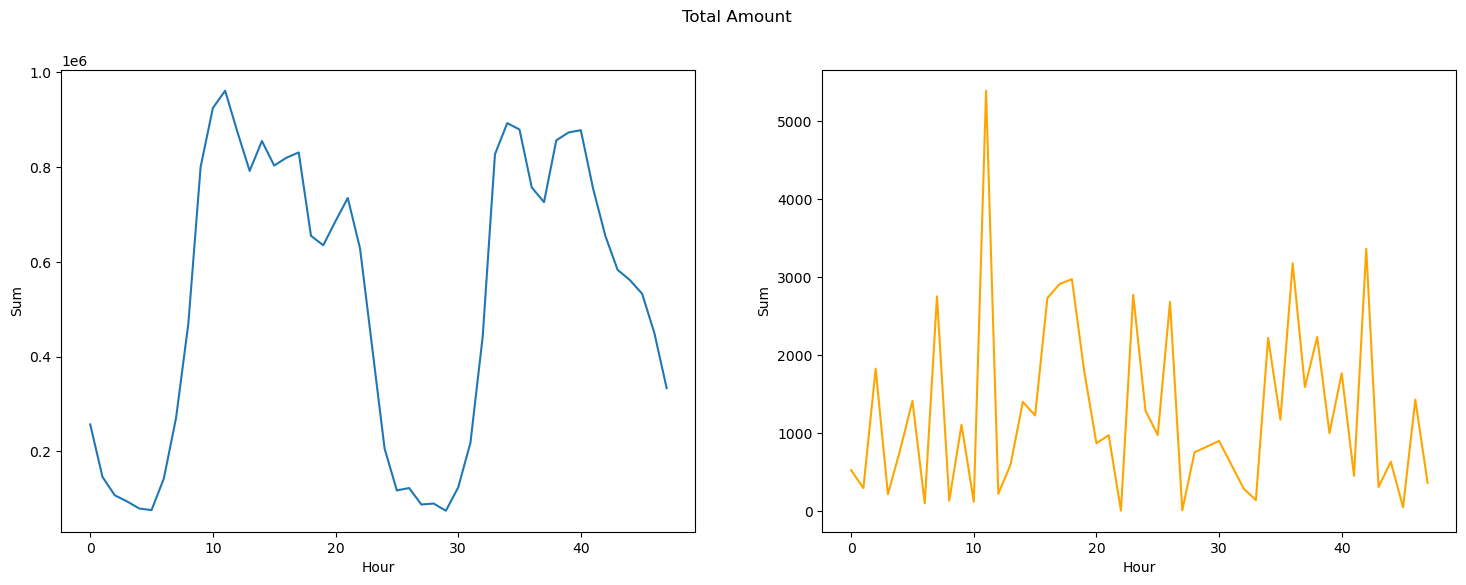

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=data.loc[data.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=data.loc[data.Class==1], color="orange")
plt.suptitle("Total Amount")
plt.show()

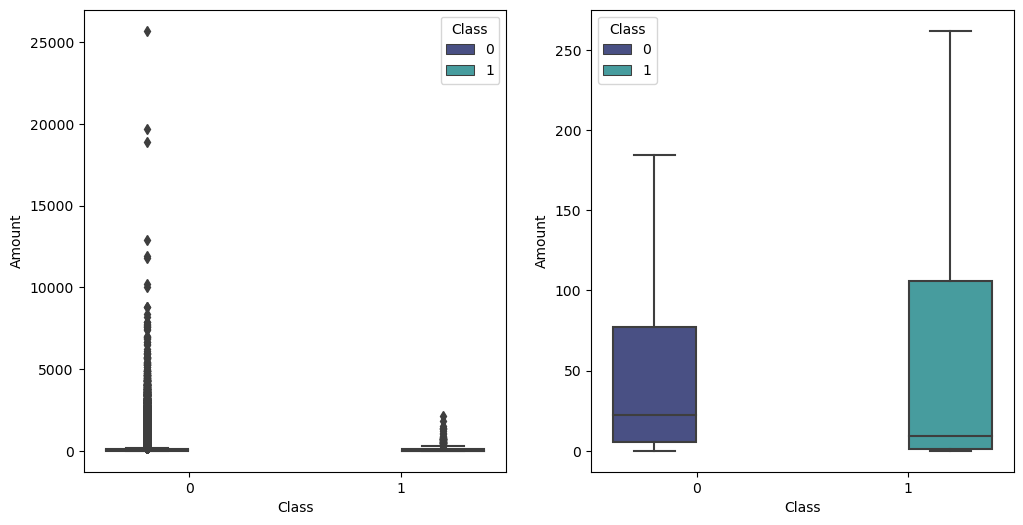

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="mako",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="mako",showfliers=False)
plt.show()

# Machine Learning Models

In [11]:
X = df.drop(['Class'], axis=1)
y = df['Class']

Splitting and Balancing Dataset

In [12]:
### StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,
                                          test_size=0.3,
                                          random_state=42)

feature_cols = df.columns[:-1]
train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df.Class))

# Create the dataframes
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'Class']

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'Class']

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64


In [13]:
print(f"Training dataset shape, X_train: {X_resampled.shape}, y_train: {y_resampled.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (398040, 31), y_train: (398040,)
Testing dataset shape, X_test: (85443, 31), y_test: (85443,)


## 1. DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=15,  min_samples_leaf=5, random_state=42)
dt = dt.fit(X_resampled, y_resampled)

In [27]:
dt.tree_.node_count, dt.tree_.max_depth

(3, 1)

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [29]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,1.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0


## 2. KNN (K- Nearest Neighbors)Algorithm.


In [30]:
from sklearn.neighbors import KNeighborsClassifier
n = np.arange(1, 30)
knn = KNeighborsClassifier(n_neighbors = 10, metric='minkowski', n_jobs=1, leaf_size=5)
    
knn = knn.fit(X_resampled, y_resampled)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     85295
           1       0.01      0.45      0.02       148

    accuracy                           0.94     85443
   macro avg       0.51      0.69      0.50     85443
weighted avg       1.00      0.94      0.97     85443

Accuracy score:  0.94
F1 Score:  0.02


In [31]:
neighbors = np.arange(1, 7)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors = 100, metric='minkowski', n_jobs=5, leaf_size=5)
    
    #Fit the model
    knn = knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

    test_accuracy[i] = knn.score(X_test, y_test)

#print the accuracy result
accuracy = accuracy_score(y_test, y_test)
print("Train Accuracy:", train_accuracy[i])
print("Test Accuracy:", test_accuracy[i])

Train Accuracy: 0.9982745129511847
Test Accuracy: 0.9982678510820079


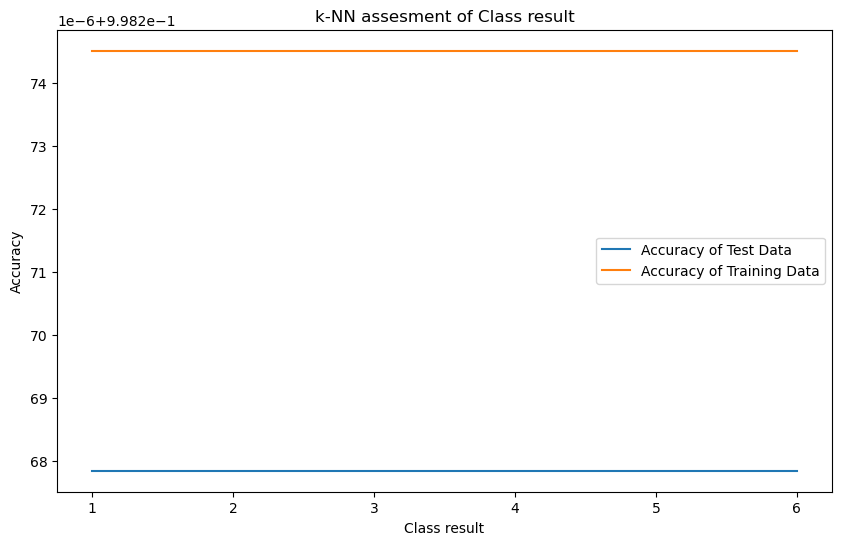

In [32]:
plt.figure(figsize=(10,6))
plt.title('k-NN assesment of Class result')
plt.plot(neighbors, test_accuracy, label='Accuracy of Test Data')
plt.plot(neighbors, train_accuracy, label='Accuracy of Training Data')
plt.legend()
plt.xlabel('Class result')
plt.ylabel('Accuracy')
plt.show()

### Using Cross Validation to Get the Best Value of k

Text(0, 0.5, 'Accuracy Score')

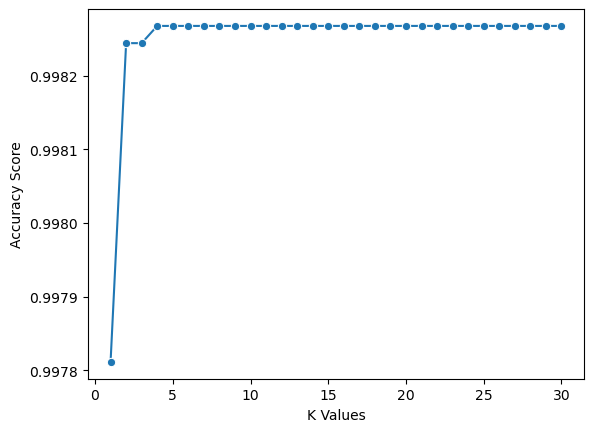

In [27]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    score = cross_val_score(knn,X_test, y_test, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

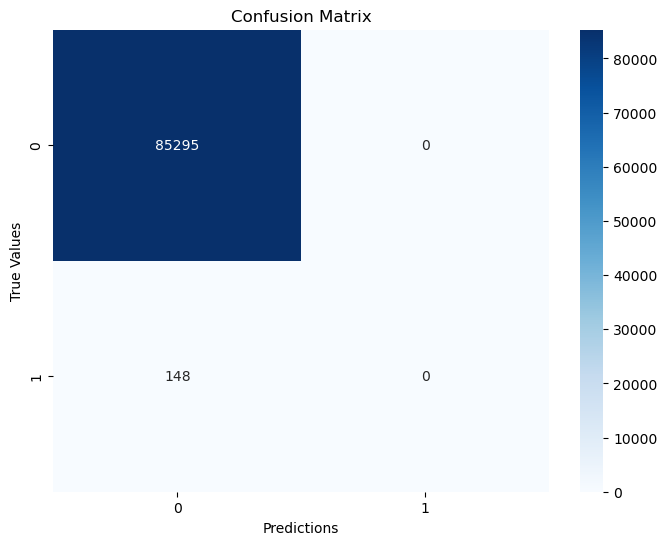

In [28]:
# Plot confusion matrix
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()

## 3. Adabooster


In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

In [30]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)

In [31]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85349
           1       0.54      0.85      0.66        94

    accuracy                           1.00     85443
   macro avg       0.77      0.93      0.83     85443
weighted avg       1.00      1.00      1.00     85443



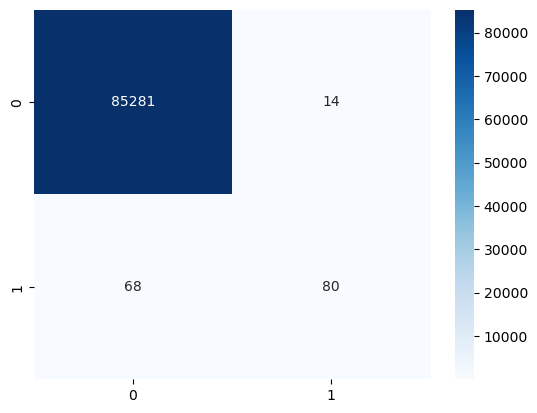

In [32]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## 4. XGBOOST

In [33]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, objective='binary:logistic')
#Fit the model
XGB.fit(X_resampled, y_resampled)
pred_xgb = XGB.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred_xgb)
F1_score = f1_score(y_test, pred_xgb)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')
print(classification_report(y_test, pred_xgb))

Accuracy: 1.0
F1_score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00       148

    accuracy                           1.00     85443
   macro avg       1.00      1.00      1.00     85443
weighted avg       1.00      1.00      1.00     85443



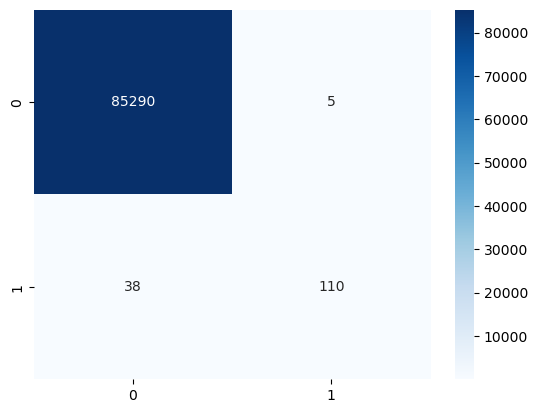

In [34]:
cm = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()


## 5. Stacking model - ensembling

In [35]:
from sklearn.ensemble import VotingClassifier

# The combined model
estimators = [('dt', dt), ('GV_ABC', GV_ABC), ('Knn', knn), ('XGB', XGB)]

# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME alg

In [36]:
VC.estimators_

[DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, random_state=42),
 GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1)),
              n_jobs=-1,
              param_grid={'learning_rate': [0.01, 0.001],
                          'n_estimators': [100, 150, 200]},
              scoring='accuracy'),
 KNeighborsClassifier(n_neighbors=30),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_

Predict

In [37]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))
#EVALUATION SCORE
accuracy = accuracy_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.99      0.62      0.76       148

    accuracy                           1.00     85443
   macro avg       0.99      0.81      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy: 0.9993328885923949
F1_score: 0.7634854771784232


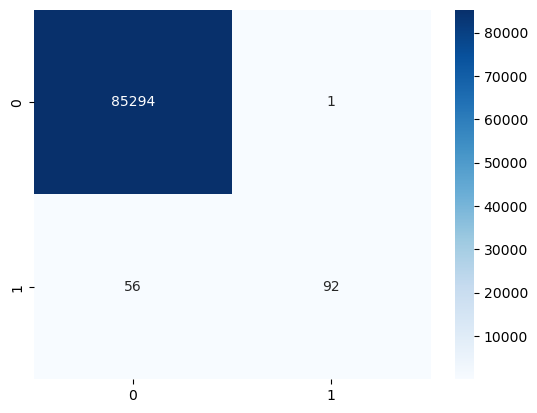

In [38]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

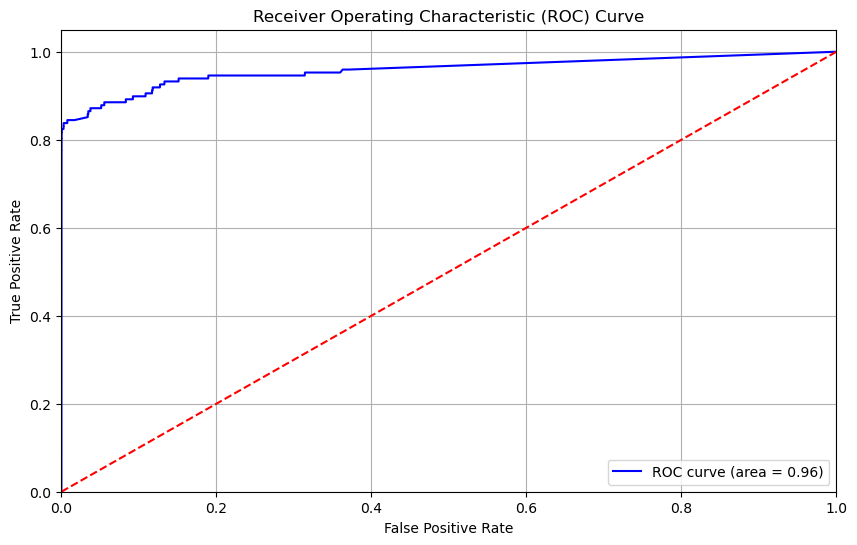

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_scores = VC.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Model evaluation

In [22]:
# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 5, 10]
}

# Define estimators for VotingClassifier
estimators = [
    ('dt', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=15,  min_samples_leaf=5, random_state=42)),
    ('adaboostRF', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42))),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
]

# Define models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=15,  min_samples_leaf=5, random_state=42),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)),
    "Voting Classifier": VotingClassifier(estimators, voting='soft')
}

# Train models and evaluate performance
results = {}

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='binary')  # Use 'weighted' for multi-class
    results[model_name] = {'accuracy': acc, 'f1_score': f1}
# Create a DataFrame for results
results_df = pd.DataFrame(results).T
print(results_df)

/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


               accuracy  f1_score
XGBoost        0.999415  0.827586
Decision Tree  0.996091  0.409894
KNN            0.943658  0.027868
AdaBoost       0.989935  0.226619
Stack Model    0.998631  0.675900
